In [1]:
# Import libs
import os 
import time
import cv2
from tqdm import tqdm
import numpy as np
import skimage.draw
import random
import keras
import matplotlib.pyplot as plt
import matplotlib.colors
from skimage.transform import resize
import efficientnet.tfkeras
from tensorflow.keras.models import load_model



def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)

        
# Name experiment
experiment_name = "exp_1"
        
# Define paths
dataset_name = "test_images" 
base_path = os.path.abspath(".")
test_dataset_path = os.path.join(base_path, "dataset", dataset_name)
log_path = os.path.join(base_path, "logs", experiment_name)
print(test_dataset_path)

Using TensorFlow backend.


/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/test_images


In [2]:
model = None
model = load_model('{}/{}.h5'.format(log_path, experiment_name), compile=False)
#model.summary()

In [3]:
import numpy as np
from skimage.transform import resize

# Helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

    
    n = len(images)
    plt.figure(figsize=(16, 16))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=map_name, norm=norm)
    plt.show()
    
    
    
def prep(img):
    img = img.astype('float32')
    img = (img > 0.5).astype(np.uint8)  # threshold
    img = resize(img, (image_cols, image_rows), preserve_range=True)
    return img




def visualize_results(image, mask):
    
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap=map_name, norm=norm)


    
def vis_gray(image, mask):
    
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    
    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap='gray')
    
    
    
    
def sliding_window(image, step, window):
    
    x_loc = []
    y_loc = []
    cells = []
    
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
            
    return x_loc, y_loc, cells




def predict(im):
    """Predict on patch"""
    
    im = np.expand_dims(im, axis=0)
    
    im = model.predict(im)
    im = np.argmax(im.squeeze(), axis=-1)
 
    assert im.shape == (64, 64), "Wrong shape, {}!".format(im.shape)
    
    return im



def whole_slide_predict(whole_image):
    
    # If input image less than patch, infer on whole image
    if whole_image.shape[0] < 64 or whole_image.shape[1] < 64:
        
        # Get size
        raw_dim = (whole_image.shape[1], whole_image.shape[0]) # W, H
        
        # Resize to 64x64 for prediction
        whole_image_rs = cv2.resize(whole_image, (64, 64), interpolation = cv2.INTER_AREA)
        #whole_image_rs = resize(whole_image, (64, 64), preserve_range=True)
        
        # Infer
        pred = predict(whole_image_rs)
        
        # Change dtype for resizing back to original shape
        pred = pred.astype(np.uint8)
        
        # Resize back to original shape
        pred = cv2.resize(pred, raw_dim, interpolation = cv2.INTER_AREA)
        #pred = resize(pred, raw_dim, preserve_range=True)
        
    
    else:
        
        # Get patch locations
        x_pos, y_pos, cells = sliding_window(whole_image, 8, (64, 64)) 

        # Array for storing predictions
        pred = np.zeros((whole_image.shape[0], whole_image.shape[1]))

        # Slide over each patch
        for (x, y, cell) in zip(x_pos, y_pos, cells):

            # Get patch
            patch = whole_image[y:y + 64, x:x + 64]

            # Get size
            raw_dim = (patch.shape[1], patch.shape[0]) # W, H

            # If less than patch size, resize and then run prediction
            if raw_dim != (64, 64):


                # Resize to 64x64
                patch_rs = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)
                #patch_rs = resize(patch, (64, 64), preserve_range=True)
                #patch_rs = patch_rs.astype(np.uint8)
                
                assert patch.dtype == patch_rs.dtype, "Wrong data type after resizing!"

                
                # Infer
                processed = predict(patch_rs)
                
                # Change dtype for resizing to original shape
                processed = processed.astype(np.uint8)


                # Resize back to original shape
                processed = cv2.resize(processed, raw_dim, interpolation = cv2.INTER_AREA)
                #processed = resize(processed, raw_dim, preserve_range=True)
                
                # Change dtype 
                processed = processed.astype(np.uint8)
                
                assert patch.shape[:2] == processed.shape, "Wrong shape!"
                assert patch.dtype == processed.dtype, "Wrong data type in prediction!"

            else:

                
                # Infer
                processed = predict(patch)
                
                # Change dtype
                processed = processed.astype(np.uint8)

                #print(patch.dtype, processed.dtype)

                assert patch.shape[:2] == processed.shape, "Wrong shape!"
                assert patch.dtype == processed.dtype, "Wrong data type in prediction!"


            # Add in image variable
            pred[y:y + 64, x:x + 64] = processed 
            processed = None

    return pred


### Run inference on a random single image

Index:  72
Image shape: (222, 222, 3)
float64
(222, 222, 3) (222, 222)
Uniques predicted [0. 1. 2.]


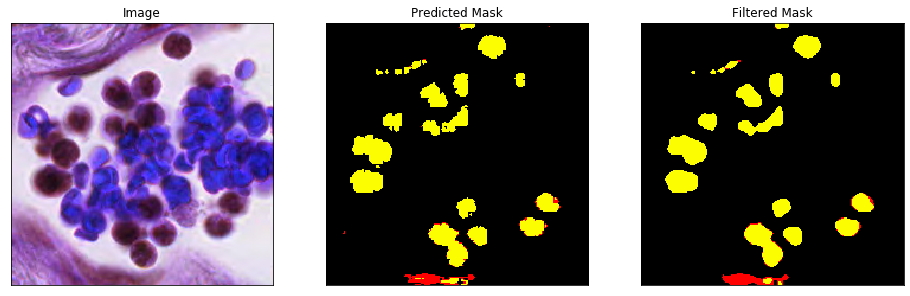

In [62]:
image_fns = sorted(next(os.walk(test_dataset_path))[2])

idx = random.randrange(len(image_fns))
print("Index: ",idx)

image = skimage.io.imread(os.path.join(test_dataset_path, image_fns[1]))
print("Image shape:", image.shape)

pred = whole_slide_predict(image)
print(pred.dtype)

# Post processing to refine predictions
pred_filt = cv2.medianBlur(pred.astype(np.uint8), 5)

print(image.shape, pred.shape)
print("Uniques predicted", np.unique(pred))
assert image.shape[:2] == pred.shape, "Image missmatch"

#visualize_results(image, pred)

visualize(
        image=image,
        Predicted_mask = pred,
        Filtered_mask = pred_filt
    )

### Infer all test images

In [ ]:
for i in tqdm(range(len(image_fns[:]))):

    image = skimage.io.imread(os.path.join(test_dataset_path, image_fns[i]))

    pred = whole_slide_predict(image)

    visualize_results(image, pred)
    
    assert image.shape[:2] == pred.shape, "Image missmatch"

In [ ]:
from pynotify import send_email, send_email_with_attachment

subject = "Experiment results"
message = "Done!"

dest = "hasibzunair@gmail.com" 

# sends an email
send_email(dest, subject, message)